In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
import h5py
from dotenv import load_dotenv
import yaml
from ticker_download_manager import TickerDownloadManager
from date_manager import DateManager
from ticker_predict_upload import TickerPredictUpload
from s3_uploader import S3Uploader

In [2]:
tdm = TickerDownloadManager(os.path.join("input", "annual"))
dm = DateManager()
tpu = TickerPredictUpload()

### Get the past year of ticker close prices

In [3]:
long_df, start_date, end_date = tdm.get_latest_tickers(days_in_past=252, use_cache=False)
print(f"{start_date} to {end_date}")
long_df

XBI. Acquired 252 so far. Sleeping 10 seconds...
QQQ. Acquired 504 so far. Sleeping 10 seconds...
XLE. Acquired 756 so far. Sleeping 10 seconds...
VOO. Acquired 1008 so far. Sleeping 10 seconds...
NVDA. Acquired 1260 so far. Sleeping 10 seconds...
VXUS. Acquired 1512 so far. Sleeping 10 seconds...
GLD. Acquired 1764 so far. Sleeping 10 seconds...
IBIT. Acquired 2016 so far. Sleeping 10 seconds...
FXE. Acquired 2268 so far. Sleeping 10 seconds...
ETHA. Acquired 2482 so far. Sleeping 10 seconds...
2024-05-28 00:00:00 to 2025-05-29 23:59:59


,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2024-05-28 23:59:59,XBI,90.680,90.940,88.195,89.130,9042156.0,89.0615,96943
2024-05-28 23:59:59,VOO,487.400,487.645,484.525,487.120,4034716.0,486.6112,162555
2024-05-28 23:59:59,NVDA,110.244,114.939,109.883,113.901,652354890.0,112.6298,1706145
2024-05-28 23:59:59,VXUS,61.860,61.919,61.435,61.620,3560778.0,61.6378,17216
2024-05-28 23:59:59,QQQ,459.180,459.740,456.690,459.680,26180815.0,458.6121,251917
...,...,...,...,...,...,...,...,...
2025-05-29 23:59:59,VOO,545.150,545.280,538.740,542.320,4663930.0,542.4150,148186
2025-05-29 23:59:59,XLE,81.780,82.260,81.260,82.260,11891293.0,81.8643,106830
2025-05-29 23:59:59,QQQ,526.330,526.480,517.320,519.930,58723510.0,520.8382,733423


### Pivot the close prices for better analysis

In [4]:
wide_df = tpu.pivot_ticker_close_wide(long_df)
date_from = wide_df.index[0]
date_to = wide_df.index[-1]
wide_df

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
2024-05-28 17:00:00,NaN,100.3746,218.19,38.98,113.901,459.68,487.12,61.62,89.13,92.31
2024-05-29 17:00:00,NaN,99.8204,216.16,38.32,114.825,456.44,483.69,60.59,87.48,90.68
2024-05-30 17:00:00,NaN,100.0905,216.57,39.16,110.500,451.55,480.44,60.97,88.96,90.94
2024-05-31 17:00:00,NaN,100.2900,215.30,38.55,109.633,450.71,484.62,61.27,89.13,93.20
2024-06-03 17:00:00,NaN,100.5600,217.22,39.44,115.000,453.13,485.15,61.53,91.42,90.76
...,...,...,...,...,...,...,...,...,...,...
2025-05-22 17:00:00,19.99,104.0800,303.11,63.23,132.830,514.00,536.02,66.53,79.25,81.73
2025-05-23 17:00:00,19.38,104.8900,309.75,61.83,131.290,509.24,532.40,66.75,79.04,81.99
2025-05-27 17:00:00,20.38,104.6400,304.50,62.50,135.500,521.22,543.34,67.40,79.30,82.70
2025-05-28 17:00:00,19.84,104.2400,303.81,60.79,134.810,518.91,540.24,66.82,78.77,81.65


### Are there any missing values?

In [5]:
wide_df.isna().sum().sum()

np.int64(38)

### Calculate % change and covert to a percentage

In [6]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
2024-05-29 17:00:00,NaN,-0.552132,-0.930382,-1.693176,0.811231,-0.704838,-0.704139,-1.671535,-1.851229,-1.765789
2024-05-30 17:00:00,NaN,0.270586,0.189674,2.192067,-3.766601,-1.071335,-0.671918,0.627166,1.691815,0.286723
2024-05-31 17:00:00,NaN,0.199320,-0.586415,-1.557712,-0.784615,-0.186026,0.870036,0.492045,0.191097,2.485155
2024-06-03 17:00:00,NaN,0.269219,0.891779,2.308690,4.895424,0.536931,0.109364,0.424351,2.569281,-2.618026
2024-06-04 17:00:00,NaN,-0.159109,-0.897707,1.850913,1.249565,0.273652,0.121612,-0.650089,-0.273463,-0.958572
...,...,...,...,...,...,...,...,...,...,...
2025-05-22 17:00:00,5.044666,-0.392382,-0.886142,2.330474,0.781487,0.187120,0.046662,-0.165066,-0.100845,-0.390006
2025-05-23 17:00:00,-3.051526,0.778248,2.190624,-2.214139,-1.159377,-0.926070,-0.675348,0.330678,-0.264984,0.318121
2025-05-27 17:00:00,5.159959,-0.238345,-1.694915,1.083616,3.206642,2.352525,2.054846,0.973783,0.328947,0.865959
2025-05-28 17:00:00,-2.649657,-0.382263,-0.226601,-2.736000,-0.509225,-0.443191,-0.570545,-0.860534,-0.668348,-1.269649


### Calculate mean returns

In [7]:
mean_returns = returns_df.mean()
mean_returns

ticker
ETHA   -0.005862
FXE     0.019081
GLD     0.140655
IBIT    0.227382
NVDA    0.148620
QQQ     0.061902
VOO     0.050297
VXUS    0.039780
XBI    -0.025349
XLE    -0.033235
dtype: float64

### Calculate covariance matrix

In [8]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov

ticker,ETHA,FXE,GLD,IBIT,NVDA,QQQ,VOO,VXUS,XBI,XLE
ticker,,,,,,,,,,
ETHA,23.713060,-0.134094,0.058271,12.828635,6.915089,4.369581,3.298803,2.248468,3.199322,2.213287
FXE,-0.134094,0.265824,0.248651,0.003316,-0.120296,-0.081505,-0.071480,0.155106,0.011529,-0.163185
GLD,0.058271,0.248651,1.270160,0.334691,0.433536,0.205310,0.147395,0.478316,0.214940,0.204450
IBIT,12.828635,0.003316,0.334691,11.160251,3.858623,2.252467,1.708563,1.205118,1.801865,1.273905
NVDA,6.915089,-0.120296,0.433536,3.858623,13.759873,4.808063,3.325373,2.077126,2.699401,1.931946
QQQ,4.369581,-0.081505,0.205310,2.252467,4.808063,2.598450,1.921699,1.260882,1.780834,1.327676
VOO,3.298803,-0.071480,0.147395,1.708563,3.325373,1.921699,1.519376,1.010237,1.464801,1.222188
VXUS,2.248468,0.155106,0.478316,1.205118,2.077126,1.260882,1.010237,1.160964,1.082934,0.917645
XBI,3.199322,0.011529,0.214940,1.801865,2.699401,1.780834,1.464801,1.082934,3.080442,1.099779


### Simulate 10,000 portfolios by generating random weights

Softmax is used to generate random vector of positive floats summing to 1.0. Not used if short selling is allowed in the simulations.

In [9]:
def softmax_random_distribution(D):
    """
    Generates a NumPy array of D random floats that sum to 1.0 using the softmax function.

    The process involves:
    1. Generating D random numbers (from a standard normal distribution).
    2. Applying the softmax function to these numbers. Softmax converts a vector
        of numbers into a probability distribution where each element is non-negative
        and all elements sum to 1.0.

    Parameters
    ----------
    D : int 
        The desired number of elements (dimension) in the output array.
        Must be a positive integer.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (D,) containing floats that sum to 1.0.

    Raises
    ------
    ValueError: If D is not a positive integer.
    """
    if not isinstance(D, int) or D <= 0:
        raise ValueError("Dimension D must be a positive integer.")
    random_inputs = np.random.randn(D)
    stable_inputs = random_inputs - np.max(random_inputs)
    exponentials = np.exp(stable_inputs)
    softmax_output = exponentials / np.sum(exponentials)
    return softmax_output

In [10]:
n_portfolios = 10_000
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    D = len(tdm.tickers)
    w = np.random.random(D) * rand_range - rand_range / 2  # Allows short selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    # w = softmax_random_distribution(D)  # No short selling
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

### Calculate minimum variance portfolio

In [11]:
weight_bounds = [(-0.5, None)] * D  # Allows shorting
# weight_bounds = [(0.0, 1.0) for _ in range(D)]  # No shorting

In [12]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [13]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [14]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.15269313824373631
       x: [-1.005e-02  8.423e-01  2.185e-02  5.065e-03 -1.859e-02
           -1.798e-01  5.911e-01 -2.773e-01 -3.123e-02  5.678e-02]
     nit: 14
     jac: [ 3.054e-01  3.054e-01  3.053e-01  3.053e-01  3.054e-01
            3.053e-01  3.054e-01  3.054e-01  3.054e-01  3.054e-01]
    nfev: 159
    njev: 14

In [15]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.3907596937297094),
 array([-0.01005112,  0.84225376,  0.02185284,  0.00506493, -0.01859325,
        -0.17980754,  0.59107844, -0.27734782, -0.03122546,  0.05677521]),
 np.float64(0.024063233358665337))

### Calculate efficient frontier

In [16]:
num_portfolios = 100
max_simulated_return = max(simulated_returns)
print(f"Possible returns range: {min_var_return:.4f} to {max_simulated_return:.4f}")
target_returns = np.linspace(min_var_return, max_simulated_return, num_portfolios)
target_returns

Possible returns range: 0.0241 to 0.6783


array([0.02406323, 0.03067158, 0.03727992, 0.04388826, 0.0504966 ,
       0.05710495, 0.06371329, 0.07032163, 0.07692997, 0.08353832,
       0.09014666, 0.096755  , 0.10336334, 0.10997169, 0.11658003,
       0.12318837, 0.12979671, 0.13640506, 0.1430134 , 0.14962174,
       0.15623008, 0.16283843, 0.16944677, 0.17605511, 0.18266345,
       0.1892718 , 0.19588014, 0.20248848, 0.20909682, 0.21570517,
       0.22231351, 0.22892185, 0.23553019, 0.24213854, 0.24874688,
       0.25535522, 0.26196356, 0.26857191, 0.27518025, 0.28178859,
       0.28839693, 0.29500528, 0.30161362, 0.30822196, 0.31483031,
       0.32143865, 0.32804699, 0.33465533, 0.34126368, 0.34787202,
       0.35448036, 0.3610887 , 0.36769705, 0.37430539, 0.38091373,
       0.38752207, 0.39413042, 0.40073876, 0.4073471 , 0.41395544,
       0.42056379, 0.42717213, 0.43378047, 0.44038881, 0.44699716,
       0.4536055 , 0.46021384, 0.46682218, 0.47343053, 0.48003887,
       0.48664721, 0.49325555, 0.4998639 , 0.50647224, 0.51308

In [17]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [18]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [19]:
print("Weight bounds", weight_bounds)

optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        optimized_risks.append(np.nan)
        print(f"Infeasible target return: {target_return:.4f}")

Weight bounds [(-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None)]


### Calculate Sharpe Ratio

In [20]:
today_date = dm.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

2024-05-30 07:08:31.167025 2025-05-30 07:08:31.167025
0.016825396825396827


In [21]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [22]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.1903723374034818
       x: [-2.667e-01 -2.907e-01  9.766e-01  4.063e-01 -3.451e-02
           -5.000e-01  2.064e+00 -4.088e-01 -4.458e-01 -5.000e-01]
     nit: 38
     jac: [-3.052e-03 -3.211e-03 -3.101e-03 -2.987e-03 -2.946e-03
            7.401e-04 -3.176e-03 -3.153e-03 -3.288e-03  9.093e-03]
    nfev: 418
    njev: 38

In [23]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.1903723374034818),
 array([-0.26666848, -0.2907323 ,  0.97663053,  0.40631763, -0.03451455,
        -0.5       ,  2.06357529, -0.40875928, -0.44584884, -0.5       ]))

In [24]:
best_weights_pct = pd.Series(best_weights * 100, index=mean_returns.index)
best_weights_pct

ticker
ETHA    -26.666848
FXE     -29.073230
GLD      97.663053
IBIT     40.631763
NVDA     -3.451455
QQQ     -50.000000
VOO     206.357529
VXUS    -40.875928
XBI     -44.584884
XLE     -50.000000
dtype: float64

In [25]:
best_weights_pct_dict = best_weights_pct.to_dict()
best_weights_pct_dict

{'ETHA': -26.666848310309522,
 'FXE': -29.07322958733959,
 'GLD': 97.66305295378996,
 'IBIT': 40.63176258089495,
 'NVDA': -3.4514553650683073,
 'QQQ': -49.999999999999986,
 'VOO': 206.35752909513712,
 'VXUS': -40.875927782166734,
 'XBI': -44.58488358493791,
 'XLE': -50.0}

### Calculate tangency line

In [26]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

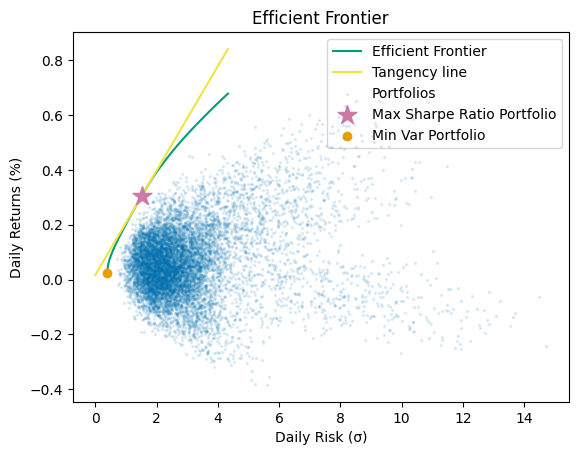

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Daily Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [28]:
annualized_optimum_return = ((1 + opt_return / 100) ** 252 - 1) * 100
annualized_optimum_risk = opt_risk * np.sqrt(252)
print(annualized_optimum_return, annualized_optimum_risk)

115.50026313261318 24.04191385592552


### Write an HDF5 file with everything needed to regenerate plot

In [29]:
portfolio_optimization_plot_data_filename = os.path.join(
    "output", "portfolio_optimization_plot_data.h5"
)
with h5py.File(portfolio_optimization_plot_data_filename, "w") as hf:
    efficient_frontier_group = hf.create_group("efficient_frontier")
    tangency_line_group = hf.create_group("tangency_line")
    simulated_portfolios_group = hf.create_group("simulated_portfolios")
    max_sharpe_ratio_group = hf.create_group("max_sharpe_ratio")
    min_var_portfolio_group = hf.create_group("min_var_portfolio")
    efficient_frontier_group.create_dataset("xs", data=optimized_risks)
    efficient_frontier_group.create_dataset("ys", data=target_returns)
    tangency_line_group.create_dataset("xs", data=tangency_xs)
    tangency_line_group.create_dataset("ys", data=tangency_ys)
    simulated_portfolios_group.create_dataset("xs", data=simulated_risks)
    simulated_portfolios_group.create_dataset("ys", data=simulated_returns)
    max_sharpe_ratio_group.create_dataset("xs", data=[opt_risk])
    max_sharpe_ratio_group.create_dataset("ys", data=[opt_return])
    min_var_portfolio_group.create_dataset("xs", data=[min_var_risk])
    min_var_portfolio_group.create_dataset("ys", data=[min_var_return])
print(f"Saved {portfolio_optimization_plot_data_filename}")

Saved output/portfolio_optimization_plot_data.h5


In [30]:
load_dotenv()
s3u = S3Uploader()

space_name = os.getenv("PORTFOLIO_OPTIMIZATION_SPACE_NAME")
s3u.upload_file(
    portfolio_optimization_plot_data_filename,
    space_name,
    "portfolio_optimization_plot_data.h5",
)

Upload of portfolio-optimization/portfolio_optimization_plot_data.h5 successful!


### Upload metadata about the plot for the front end UI

In [31]:
metadata = {
    "date_updated": {
        "date_from": str(date_from.date()),
        "date_to": str(date_to.date()),
    },
    "tickers": tdm.tickers,
    "risk_free_rate": risk_free_rate_data,
    "optimum_portfolio": {
        "annualized_return": float(annualized_optimum_return),
        "risk": float(annualized_optimum_risk),
        "weights": best_weights_pct_dict
    }
}

metadata_filename = os.path.join("output", "optimization_metadata.yml")
with open(metadata_filename, "w") as f:
    yaml.dump(metadata, f, default_flow_style=False)

s3u.upload_file(
    metadata_filename,
    space_name,
    "optimization_metadata.yml",
)

Upload of portfolio-optimization/optimization_metadata.yml successful!
